<a href="https://colab.research.google.com/github/one-2730/ESAA-24-2/blob/Assignment/ESAA_YB_0930_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##모델 평가

##분류 모델의 평가 지표


- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC, AUC

##정확도(Accuracy)

예측 결과가 맞은 수(True) / 전체 수(True & False)   
(TN + TP)/(TN + FP + FN + TP)

In [1]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
  def fit(self, X, y = None):
    pass

  def predict(self, X):
    pred = np.zeros((X.shape[0], 1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i] == 1:
        pred[i] = 0
      else:
        pred[i] = 1
    return pred

In [2]:
from sklearn.preprocessing import LabelEncoder

def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace = True)
  df['Cabin'].fillna('N', inplace = True)
  df['Embarked'].fillna('N', inplace = True)
  df['Fare'].fillna(0, inplace = True)
  return df

def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
  return df

def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도: 0.7877


In [4]:
from sklearn.datasets import load_digits

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

digits = load_digits()

y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [5]:
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
Name: count, dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


##오차행렬(Confusion Marix)

|||예측 클래스||
|-|-|-----|-----|
|||Negative|Positive|
|**실제 클래스**|Negative|True Negative|False Positive|
||Positive|False Negative|True Positive|

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

##정밀도(Precison), 재현율(Recall)

정밀도 = TP / (FP + TP) Positive로 예측된 수 中 정답 수   
  - 제 2종의 오류를 낮추는 데 초점      

재현율 = TP / (FN + TP) 실제 Positive 수 中 정답 수
  - 제 1종의 오류를 낮추는 데 초점

*정밀도와 재현율을 트레이드오프 관계에 있음
즉, 한쪽이 오르면 한쪽이 떨어질 수 있음

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, pair_confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [8]:
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [9]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba() 결과 shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [10]:
from sklearn.preprocessing import Binarizer

X = [[-1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
custom_threshold = 0.5

pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [12]:
custom_threshold = 0.4

pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


In [13]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1,thresholds):
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('\n임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임곗값: 0.4
오차행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197

임곗값: 0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869

임곗값: 0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705

임곗값: 0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377

임곗값: 0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


In [14]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 shape:', thresholds.shape)

thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임곗값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 shape: (165,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임곗값별 정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임곗값별 재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


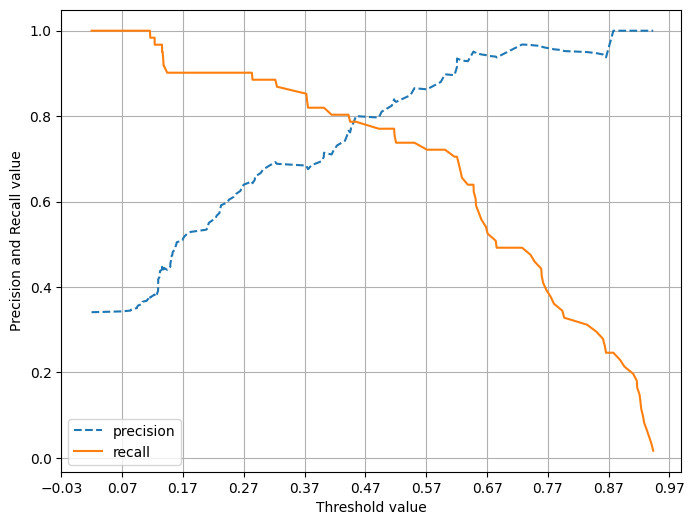

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  plt.figure(figsize = (8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  plt.xlabel('Threshold value')
  plt.ylabel('Precision and Recall value')
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

###정밀도와 재현율의 맹점

- 정밀도가 100%가 되는 방법   
  : 정말 확실할 때만 positive로 예측하고 나머지는 모두 negative로 예측하면 정밀도를 100으로 만들 수 있음. but 모델의 쓸모가 없어질 수 있음

- 재현율이 100%가 되는 방법   
  : 모든 환자를 positive로 예측하면 재현율이 100.

##F1 스코어

F1 = 2* (precision*recall)/(precision+recall)   
정밀도와 재현율이 하나로 치우치지 않을 때 F1 스코어가 높아짐

In [16]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [17]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임곗값: 0.4
오차행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F10.7576

임곗값: 0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F10.7869

임곗값: 0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F10.7966

임곗값: 0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F10.7965

임곗값: 0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F10.8000


##ROC, AUC

In [18]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


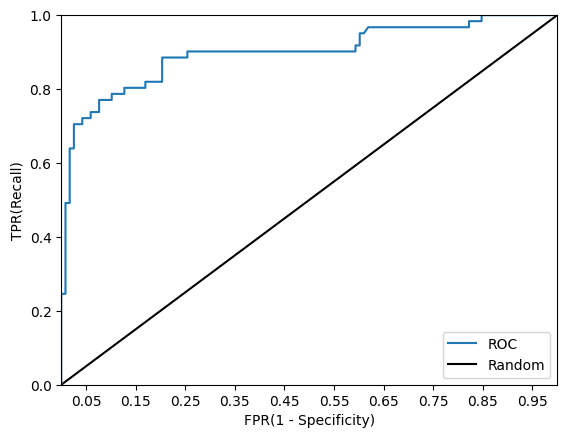

In [19]:
def roc_curve_plot(y_test, pred_proba_c1):
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  plt.plot(fprs, tprs, label = "ROC")
  plt.plot([0, 1], [0, 1], 'k-', label = 'Random')

  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('FPR(1 - Specificity)')
  plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

In [20]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987


In [21]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1{3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임곗값: 0.4
오차행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F10.7576, AUC: 0.8209

임곗값: 0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F10.7869, AUC: 0.8384

임곗값: 0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F10.7966, AUC: 0.8429

임곗값: 0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F10.7965, AUC: 0.8392

임곗값: 0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F10.8000, AUC: 0.8395


#피마 인디언 당뇨병 예측

**features**   
- Pregnancies: 임신 횟수
- Glucoses: 포도당 부하 검사 수치
- BloodPressure: 혈압(mm Hg)
- Skin Thickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
- Insulin: 혈청 인슐린(mu U/ml)
- BMI: 체질량지수(체중(kg)/키(m))^2
- DiabetesPedigreeFunction: 당뇨 내력 가중치 값
- Age: 나이
- Outcome: 클래스 결정 값(0 또는 1)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler

diabetes_df = pd.read_csv('diabetes.csv')
print(diabetes_df['Outcome'].value_counts())
diabetes_df.head()

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [23]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [24]:
X = diabetes_df.iloc[:, :-1]
y = diabetes_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)

lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926, F10.6465, AUC: 0.7313


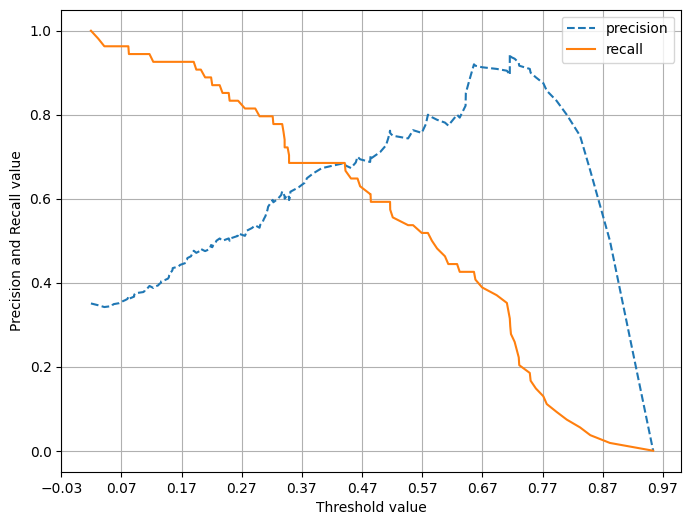

In [25]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [26]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


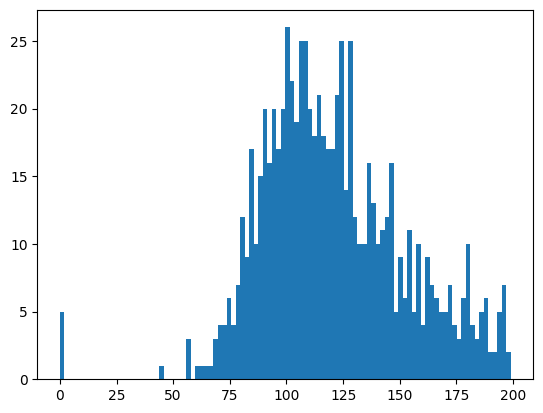

In [27]:
plt.hist(diabetes_df['Glucose'], bins = 100)
plt.show()

In [28]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
  zero_count = diabetes_df[diabetes_df[feature] == 0][feature].count()
  print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


In [29]:
X = diabetes_df.iloc[:, :-1]
y = diabetes_df.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify = y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F10.6804, AUC: 0.7556


In [30]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임곗값: 0.3
오차행렬
[[69 31]
 [13 41]]
정확도: 0.7143, 정밀도: 0.5694, 재현율: 0.7593, F10.6508, AUC: 0.7246

임곗값: 0.33
오차행렬
[[74 26]
 [17 37]]
정확도: 0.7208, 정밀도: 0.5873, 재현율: 0.6852, F10.6325, AUC: 0.7126

임곗값: 0.36
오차행렬
[[76 24]
 [18 36]]
정확도: 0.7273, 정밀도: 0.6000, 재현율: 0.6667, F10.6316, AUC: 0.7133

임곗값: 0.39
오차행렬
[[79 21]
 [19 35]]
정확도: 0.7403, 정밀도: 0.6250, 재현율: 0.6481, F10.6364, AUC: 0.7191

임곗값: 0.42
오차행렬
[[81 19]
 [20 34]]
정확도: 0.7468, 정밀도: 0.6415, 재현율: 0.6296, F10.6355, AUC: 0.7198

임곗값: 0.45
오차행렬
[[85 15]
 [20 34]]
정확도: 0.7727, 정밀도: 0.6939, 재현율: 0.6296, F10.6602, AUC: 0.7398

임곗값: 0.48
오차행렬
[[88 12]
 [21 33]]
정확도: 0.7857, 정밀도: 0.7333, 재현율: 0.6111, F10.6667, AUC: 0.7456

임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F10.6804, AUC: 0.7556


In [31]:
binarizer = Binarizer(threshold = 0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차행렬
[[88 12]
 [21 33]]
정확도: 0.7857, 정밀도: 0.7333, 재현율: 0.6111, F10.6667, AUC: 0.7456
